In [1]:
import os.path

import numpy as np
import matplotlib.pyplot as plt
import shutil

from typing import List, Tuple

In [2]:
def get_plot() -> Tuple[plt.figure, plt.axes]:
    fig, ax = plt.subplots()
    clear_and_prepare_plot(ax)
    return fig, ax


def clear_and_prepare_plot(ax) -> None:
    ax.cla()
    ax.set_aspect('equal', 'box')
    ax.set_xlim(-4, 12)
    ax.set_ylim(-4, 12)
    ax.grid(True)
    ax.set_xlabel('x position')
    ax.set_ylabel('y position')


def plot_vector(ax: plt.axes, start: np.ndarray, end: np.ndarray, color: str = None, opacity: float = 1) -> None:
    assert start.shape == (3, )
    assert end.shape == (3, )
    ax.plot(
        (start[0], end[0]),
        (start[1], end[1]),
        color=color,
        alpha=opacity
    )

In [3]:
def apply_homogeneous_transformation_matrix_to_vector(homogeneous_matrix: np.ndarray, vector: np.ndarray) -> np.ndarray:
    assert homogeneous_matrix.shape == (4, 4)
    assert vector.shape == (3, )

    extended_vector = np.hstack((vector, np.array([1], dtype=float)))
    transformed_extended_vector = homogeneous_matrix @ extended_vector

    transformed_vector = transformed_extended_vector[:3]
    return transformed_vector


def multiply_homogeneous_transformation_matrices(
    homogeneous_matrix_1: np.ndarray, homogeneous_matrix_2: np.ndarray
) -> np.ndarray:
    assert homogeneous_matrix_1.shape == (4, 4)
    assert homogeneous_matrix_2.shape == (4, 4)

    return homogeneous_matrix_1 @ homogeneous_matrix_2

In [7]:
class Robot:
    def __init__(self, initial_pose: np.ndarray = np.identity(4)):
        self.pose = initial_pose

    def plot(self, ax: plt.axes) -> None:
        # variable names and calculations are optimized for clarity, not for brevity...

        local_start_of_base_vectors = np.array([0, 0, 0], dtype=float)
        local_end_of_x_unit_vector = np.array([1, 0, 0], dtype=float)
        local_end_of_y_unit_vector = np.array([0, 1, 0], dtype=float)
        local_end_of_z_unit_vector = np.array([0, 0, 1], dtype=float)

        global_start_of_base_vectors = apply_homogeneous_transformation_matrix_to_vector(
            self.pose, local_start_of_base_vectors
        )
        global_end_of_x_unit_vector = apply_homogeneous_transformation_matrix_to_vector(
            self.pose, local_end_of_x_unit_vector
        )
        global_end_of_y_unit_vector = apply_homogeneous_transformation_matrix_to_vector(
            self.pose, local_end_of_y_unit_vector
        )
        global_end_of_z_unit_vector = apply_homogeneous_transformation_matrix_to_vector(
            self.pose, local_end_of_z_unit_vector
        )

        plot_vector(ax, global_start_of_base_vectors, global_end_of_x_unit_vector, 'red')
        plot_vector(ax, global_start_of_base_vectors, global_end_of_y_unit_vector, 'green')
        plot_vector(ax, global_start_of_base_vectors, global_end_of_z_unit_vector, 'blue')

    def move(self, homogeneous_matrix: np.ndarray) -> None:
        assert homogeneous_matrix.shape == (4, 4)
        assert self.pose.shape == (4, 4)
        # Be aware that the transformation matrix is multiplied from the right!
        # However, feel free to try out switching the order. What happens?
        self.pose = multiply_homogeneous_transformation_matrices(self.pose, homogeneous_matrix)

    def move_and_plot(self, homogeneous_matrices: List[np.ndarray]) -> None:
        output_dir = 'generated'
        if os.path.isdir(output_dir):
            shutil.rmtree(output_dir)
        os.makedirs(output_dir)

        fig, ax = get_plot()
        plt.show(block=False)
        self.plot(ax)
        fig.savefig(os.path.join(output_dir, f'step_0_(initial).png'))
        plt.pause(0.25)

        for counter, homogeneous_matrix in enumerate(homogeneous_matrices):
            self.move(homogeneous_matrix)
            clear_and_prepare_plot(ax)
            self.plot(ax)
            ax.set_title(f'Robot pose after step {counter + 1}')
            fig.savefig(os.path.join(output_dir, f'step_{counter + 1}.png'))
            plt.pause(0.25)

In [8]:
transformations: List[np.ndarray] = list()
robot = Robot(
    initial_pose=np.array([
        [1, 0, 0, 5],
        [0, 1, 0, 3],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ], dtype=float)
)

# Try out changing this parameter - if the matrices are defined correctly, the final result is the same
split_third_transformation_into_individual_ones: bool = True

# Rotate around z axis by 90°, i.e., pi
transformations.append(
    np.array([
        [np.cos(np.pi/2), -np.sin(np.pi/2), 0, 0],
        [np.sin(np.pi/2),  np.cos(np.pi/2), 0, 0],
        [              0,                0, 1, 0],
        [              0,                0, 0, 1]
    ], dtype=float)
)
# Drive straight for 4 unit lengths
transformations.append(
    np.array([
        [1, 0, 0, 4],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ], dtype=float)
)
if split_third_transformation_into_individual_ones:
    # Drive straight for 2 unit lengths
    transformations.append(
        np.array([
            [1, 0, 0, 2],
            [0, 1, 0, 0],
            [0, 0, 1, 0],
            [0, 0, 0, 1]
        ], dtype=float)
    )
    # Drive right for 3 unit lengths
    transformations.append(
        np.array([
            [1, 0, 0,  0],
            [0, 1, 0, -3],
            [0, 0, 1,  0],
            [0, 0, 0,  1]
        ], dtype=float)
    )
    # Rotate around z axis by 45°, i.e., pi/2
    transformations.append(
        np.array([
            [np.cos(np.pi/4), -np.sin(np.pi/4), 0, 0],
            [np.sin(np.pi/4),  np.cos(np.pi/4), 0, 0],
            [              0,                0, 1, 0],
            [              0,                0, 0, 1]
        ], dtype=float)
    )
else:
    # Drive straight for 2 unit lengths, drive right for 3 unit lengths, rotate around z axis by 45°, i.e., pi/2
    transformations.append(
        np.array([
            [np.cos(np.pi/4), -np.sin(np.pi/4), 0,  2],
            [np.sin(np.pi/4),  np.cos(np.pi/4), 0, -3],
            [              0,                0, 1,  0],
            [              0,                0, 0,  1]
        ], dtype=float)
    )

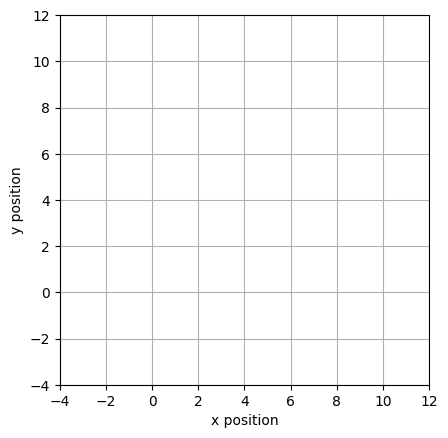

In [9]:
robot.move_and_plot(transformations)